In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [33]:
# Initial Dataframe for exploration
df = pd.read_csv('/Users/siddharthsingh/Downloads/take-home_exercise_data.csv')

In [34]:
df.head(10)

,Unnamed: 0,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
0,1,93771712,127707306,2014-11-28,More than 120 days old,Existing Reg,2014-12-10,4 weeks,NaN,1,38.0
1,2,123112555,114401425,2013-12-05,Order prior to reg,New Reg,2014-01-13,4 weeks,NaN,1,40.0
2,3,171965960,159656050,2016-11-25,Order prior to reg,New Reg,NaN,-1,Paid Search Non Brand,0,NaN
3,4,175522116,165370285,2017-03-08,<=60 days,Existing Reg,NaN,-1,Email Programs,0,NaN
4,5,149288086,132837125,2015-03-30,Order prior to reg,New Reg,2015-04-06,4 weeks,NaN,0,NaN
5,6,58994698,101317667,2012-10-26,More than 120 days old,Acom Sub,2012-11-30,4 weeks,NaN,0,NaN
6,7,172404474,166005278,2017-03-19,<=120 days,Existing Reg,2017-03-26,-1,Email Programs,0,NaN
7,8,148805471,138025122,2015-08-07,More than 120 days old,Acom Sub,2015-08-20,6 weeks,email no source id,0,NaN
8,9,83821963,153455361,2016-07-14,More than 120 days old,Acom Sub,2016-07-28,6 weeks,direct non-homepage,0,NaN
9,10,109792034,160111092,2016-11-29,More than 120 days old,Existing Reg,2016-12-21,6 weeks,Email Campaigns,0,NaN


### Data description

Column Description

- prospectid Unique identifier for customers
- ordernumber Unique DNA order id
- ordercreatedate Date DNA product was ordered
- regtenure Days since the customer registered an email address with Ancestry
- customer_type_group Customer type at the time of the DNA order
- dnatestactivationdayid Date DNA test is activated. Customers must activate their kit by visiting the
- website after ordering for testing
- daystogetresult_grp Number of days taken for the DNA test results to be ready
- dna_visittrafficsubtype DNA Traffic visit channel, example: ‘Paid Search Non Brand’
- xsell_gsa Indicates a new ACOM Subscriber Addition 
- xsell_day_exact Days between DNA sale and ACOM subscription

In [35]:
df.shape

(251942, 11)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251942 entries, 0 to 251941
Data columns (total 11 columns):
Unnamed: 0                 251942 non-null int64
prospectid                 251942 non-null int64
ordernumber                251942 non-null int64
ordercreatedate            251942 non-null object
regtenure                  251942 non-null object
customer_type_group        251942 non-null object
dnatestactivationdayid     178845 non-null object
daystogetresult_grp        251942 non-null object
dna_visittrafficsubtype    189093 non-null object
xsell_gsa                  251942 non-null int64
xsell_day_exact            40579 non-null float64
dtypes: float64(1), int64(4), object(6)
memory usage: 21.1+ MB


In [37]:
df.describe()

,Unnamed: 0,prospectid,ordernumber,xsell_gsa,xsell_day_exact
count,251942.000000,2.519420e+05,2.519420e+05,251942.000000,40579.000000
mean,125971.500000,1.144561e+08,1.455821e+08,0.161065,140.674043
std,72729.535098,5.277515e+07,1.752503e+07,0.367591,668.588251
min,1.000000,7.600000e+02,9.592366e+07,0.000000,0.000000
25%,62986.250000,7.189144e+07,1.356459e+08,0.000000,0.000000
50%,125971.500000,1.243254e+08,1.504135e+08,0.000000,22.000000
75%,188956.750000,1.649072e+08,1.599612e+08,0.000000,100.000000
max,251942.000000,1.795105e+08,1.667366e+08,1.000000,42302.000000


We consider a customer to be a cross sell (from DNA to ACOM subscription) when the following conditions are met in the data:

● xsell_gsa == 1. The customer became a new ACOM subscriber. 

● xsell_day_exact <= 120. The customer purchased their ACOM subscription within 120 days of their DNA product order.

In [38]:
df['xsell_day_exact'].isna().sum()

211363

In [39]:
# percentages of missing value
df.isnull().sum() / df.shape[0] * 100

Unnamed: 0                  0.000000
prospectid                  0.000000
ordernumber                 0.000000
ordercreatedate             0.000000
regtenure                   0.000000
customer_type_group         0.000000
dnatestactivationdayid     29.013424
daystogetresult_grp         0.000000
dna_visittrafficsubtype    24.945821
xsell_gsa                   0.000000
xsell_day_exact            83.893515
dtype: float64

### 1. Exploratory Data Analysis | Business logic - 

1. EDA | Business Process
2. What fraction of the observed customers cross-sell to subscription?
3. What is the count of customers for each type within the website traffic data. What is the subscription rate across each type.
4. Total subscriptions per year to identify the trend and inclination of people to find their DNA information
5. Compare the days for actvation vs the time to obtain results. For this, create a new column to compare the dates and find the days between order placed date and activation date. See if there is any +ve/-ve correlation.
6. Motive here is to see if the customers have a threshold of patience after which their subscription rates drop significantly. To test this, try clubbing the time for obtaining results into clusters and see if after any point, the subscription rates fall drastically

In [40]:
# Label Encoding customer_type_group where "Existing Reg" = 0,"New Reg" = 1, "Acom Sub" = 2
df.customer_type_group.unique()
df["customer_type_group"] = df["customer_type_group"].map({"Existing Reg":0,"New Reg":1, "Acom Sub":2})
df

,Unnamed: 0,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
0,1,93771712,127707306,2014-11-28,More than 120 days old,0,2014-12-10,4 weeks,NaN,1,38.0
1,2,123112555,114401425,2013-12-05,Order prior to reg,1,2014-01-13,4 weeks,NaN,1,40.0
2,3,171965960,159656050,2016-11-25,Order prior to reg,1,NaN,-1,Paid Search Non Brand,0,NaN
3,4,175522116,165370285,2017-03-08,<=60 days,0,NaN,-1,Email Programs,0,NaN
4,5,149288086,132837125,2015-03-30,Order prior to reg,1,2015-04-06,4 weeks,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
251937,251938,172434095,158455432,2016-11-01,Order prior to reg,1,2016-11-05,3 weeks,direct core homepage,1,0.0
251938,251939,177244263,166179598,2017-03-22,Order prior to reg,1,NaN,-1,direct core homepage,0,NaN
251939,251940,170036574,157706878,2016-10-15,<=60 days,0,NaN,-1,email no source id,1,0.0
251940,251941,79472105,129105293,2015-01-02,More than 120 days old,2,2015-01-17,>10weeks,direct core homepage,0,NaN


In [41]:
df.dna_visittrafficsubtype.unique()

array([nan, 'Paid Search Non Brand', 'Email Programs',
       'email no source id', 'direct non-homepage', 'Email Campaigns',
       'direct dna homepage', 'direct core homepage', 'geo-redirect',
       'paid search – dna brand', 'organic dna brand',
       'internal referrals', 'paid search – core brand',
       'Affiliate External', 'organic core brand', 'External Paid Media',
       'content marketing', 'organic nonbrand', 'Radio Brand/PR',
       'Paid Search GDN ', 'social media organic', 'iOS App', 'Inbound',
       'external referrals', 'FindAGrave', 'Direct Mail',
       'FTM Software Integration', 'Social', 'Web Property', 'Search',
       'Partners', 'Direct', 'Digital Video',
       'Telemarketing Other (short term 8/31/05)', 'Windows App',
       'TV Brand/PR', 'External Email', 'DNA App', 'Mobile',
       'Android App', 'Social Media Natural ', 'Feeders', 'Display',
       'Library/Assoc.', 'Biz Dev', 'Overlays', 'Kiosk'], dtype=object)

#### Dropping NAN values across the dataframe since Scaling and Standardisation is subjected to business process and no constraints are given for normalisation of NAN values 

In [42]:
# df_ancestry = original dataframe without NaNs
df_ancestry = df.dropna().reset_index()

In [43]:
df_ancestry.drop(['index'], axis=1, inplace=True)

In [44]:
df_ancestry.isnull().sum()

Unnamed: 0                 0
prospectid                 0
ordernumber                0
ordercreatedate            0
regtenure                  0
customer_type_group        0
dnatestactivationdayid     0
daystogetresult_grp        0
dna_visittrafficsubtype    0
xsell_gsa                  0
xsell_day_exact            0
dtype: int64

In [45]:
df_ancestry.shape

(25880, 11)

In [46]:
# Label Encoding categorical variables from 'dna_visittrafficsubtype' -> new column 'dna_visittrafficsubtype_N'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_ancestry['dna_visittrafficsubtype_N'] = le.fit_transform(df_ancestry['dna_visittrafficsubtype'])

In [47]:
df_ancestry['dna_visittrafficsubtype_N'].value_counts()

26    5160
38    3147
6     2299
15    2152
37    1760
33    1705
35    1355
28    1141
27    1089
29    1049
34     986
9      908
36     594
0      592
7      513
32     264
25     255
14     184
39     173
31     160
30     143
19      51
16      44
5       32
23      29
17      25
11      13
1       12
18      10
22       7
20       5
3        5
8        4
10       4
12       3
21       2
24       2
4        1
2        1
13       1
Name: dna_visittrafficsubtype_N, dtype: int64

In [48]:
df_ancestry.drop(['dna_visittrafficsubtype', 'Unnamed: 0'], axis=1, inplace=True)

In [49]:
df_ancestry.head()

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,xsell_gsa,xsell_day_exact,dna_visittrafficsubtype_N
0,80132869,142652370,2015-11-27,More than 120 days old,0,2015-12-01,4 weeks,1,0.0,26
1,173226869,158542275,2016-11-03,Order prior to reg,1,2016-11-09,3 weeks,1,0.0,15
2,172049320,160086365,2016-11-29,Order prior to reg,1,2016-12-23,6 weeks,1,0.0,33
3,85355806,156673941,2016-09-22,More than 120 days old,0,2016-10-01,4 weeks,1,16.0,26
4,63764822,156066418,2016-09-09,More than 120 days old,2,2016-09-16,4 weeks,1,0.0,26


 ### 2. What fraction of the observed customers cross-sell to subscription?

In [50]:
# CHECK: distribution of customer cross sell when 'xsell_gsa' == 1 and 'xsell_day_exact' <= 120
df_ancestry_cross_sell = df_ancestry[(df_ancestry['xsell_gsa'] == 1) & (df_ancestry['xsell_day_exact'] <= 120)]

In [51]:
# Fraction = cross_sell customers / subscribed customers
df_ancestry_cross_sell.shape[0] / df_ancestry[df_ancestry['xsell_gsa'] == 1].shape[0]

0.845015455950541

#### Approx 84.5% of DNA customers get converted to ACOM subscribers 

### 3. What is the count of customers for each type within the website traffic data. What is the subscription rate across each type.

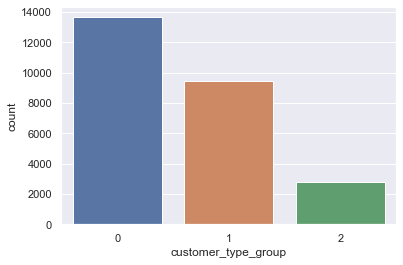

In [52]:
# Count plot for each customer_type_group "Existing Reg" = 0,"New Reg" = 1, "Acom Sub" = 2
# count of subscribed customers for each type within the website traffic data
sns.countplot(x="customer_type_group", data=df_ancestry[df_ancestry['xsell_gsa'] == 1])

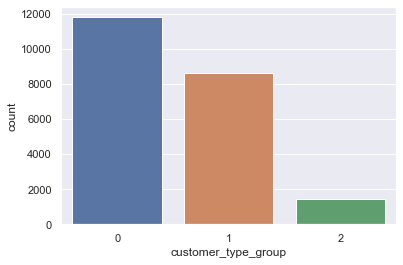

In [53]:
# Count plot for each customer_type_group "Existing Reg" = 0,"New Reg" = 1, "Acom Sub" = 2
# count of cross selling customers for each type 
sns.countplot(x="customer_type_group", data=df_ancestry_cross_sell)

#### -- Existing customers are the most likely to be CROSS-SELLING ACOM subscribers
#### -- Followed by New registers then ACOM subscribers

#### Countplot "customer_type_group" VS. 'dna_visittrafficsubtype_N'

In [54]:
df_cp = df_ancestry_cross_sell.copy()
df_cp["traffic_class"] = df.dna_visittrafficsubtype

In [55]:
df_cp = df_cp.dropna()

In [63]:
df_cp.reset_index()

,index,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,xsell_gsa,xsell_day_exact,dna_visittrafficsubtype_N,traffic_class
0,2,172049320,160086365,2016-11-29,Order prior to reg,1,2016-12-23,6 weeks,1,0.0,33,Paid Search Non Brand
1,3,85355806,156673941,2016-09-22,More than 120 days old,0,2016-10-01,4 weeks,1,16.0,26,Email Programs
2,7,170252680,157087171,2016-10-01,Order prior to reg,1,2016-10-14,4 weeks,1,0.0,34,email no source id
3,8,166883103,151008229,2016-05-24,Order prior to reg,1,2016-07-27,6 weeks,1,103.0,15,direct non-homepage
4,12,69980478,157263493,2016-10-05,More than 120 days old,0,2016-10-23,5 weeks,1,18.0,26,Email Campaigns
...,...,...,...,...,...,...,...,...,...,...,...,...
16474,25874,163455654,147006599,2016-03-01,<=10 days,0,2016-03-07,5 weeks,1,11.0,38,Paid Search Non Brand
16475,25875,167814493,151401563,2016-06-02,Order prior to reg,1,2016-07-11,5 weeks,1,14.0,26,Affiliate External
16476,25876,29796092,142605904,2015-11-26,More than 120 days old,2,2015-12-06,3 weeks,1,0.0,26,direct core homepage
16477,25877,143002040,159950607,2016-11-28,More than 120 days old,0,2016-12-25,6 weeks,1,32.0,6,direct dna homepage


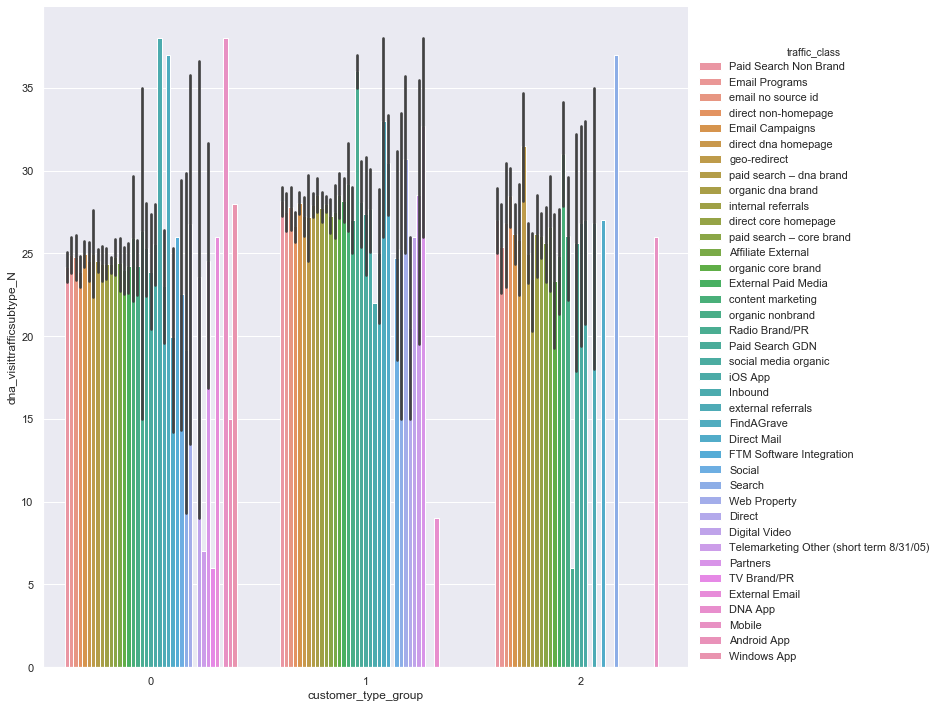

In [69]:
sns.catplot(x="customer_type_group", y="dna_visittrafficsubtype_N", hue="traffic_class", kind="bar", height=10, data=df_cp)

### 4. Total subscriptions per year to identify the trend and inclination of people to find their DNA information

In [59]:
df_ancestry_cross_sell['year'] = pd.DatetimeIndex(df_ancestry_cross_sell['ordercreatedate']).year

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
# Total subscriptions grouped by year to identify the trend and inclination of people to find their DNA information
df_ancestry_cross_sell.groupby(['year'])['xsell_gsa'].sum()

year
2014     1341
2015     4965
2016    13438
2017     2125
Name: xsell_gsa, dtype: int64

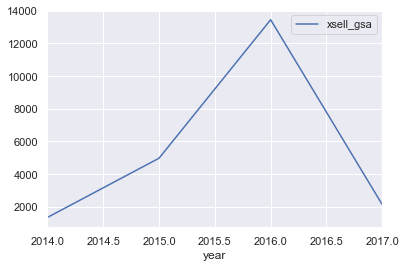

In [61]:
# Line plot of subscriptions per year
df_ancestry_cross_sell.groupby(['year'])['xsell_gsa'].sum().plot(legend=True)

#### -- The ACOM subribers grew over 2015 and peaked in 2016, followed by a steep decline

### 5. Compare the days for activation vs the time to obtain results. For this, create a new column to compare the dates and find the days between order placed date and activation date. See if there is any +ve/-ve correlation.


#### -- We can do this by Pearson correlation coefficient from scipy library where we compare 'ordercreatedate', 'dnatestactivationdayid' and 'daystogetresult_grp'

### 6. Motive here is to see if the customers have a threshold of patience after which their subscription rates drop significantly. To test this, try clubbing the time for obtaining results into clusters and see if after any point, the subscription rates fall drastically